Copyright © 2023, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Titanic Dataset : Assess Bias of a Binary Classification Model and Import into Model Manager

This notebook provides an example of how to integrate bias assessment in the python model to SAS Model Manager (on either SAS Viya or SAS Viya 4) workflow using the titanic dataset. Lines of code that must be modified by the user, such as directory paths or the host server are noted with the comment "_Changes required by user._".

_**Note:** If you download only this notebook and not the rest of the repository, you must also download the titanic.csv file from the data folder in the examples directory. These files are used when executing this notebook example._

Here are the steps shown in this notebook:

1. Import, review, and preprocess data for model training.
2. Build, train, and assess a scikit-learn decision tree, random forest, and gradient boosting model.
3. Serialize the models into separate pickle files.
4. Write the bias assessment JSON files
5. Write the metadata JSON files needed for importing into SAS Model Manager as well as optional files for fit statistics and ROC/Lift charts.
6. Write a score code Python file for model scoring.
7. Zip the pickle, JSON, and score code files into an archive file.
8. Import the ZIP archive file to SAS Model Manager via the Session object and relevant function call.

## Import Modules

In [1]:
from sasctl import Session
import sasctl.pzmm as pzmm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load and Pre-process Data

In [2]:
df_raw = pd.read_csv('data/titanic.csv')
df_raw.head()

,PassengerId,Survived,Pclass,Lname,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_raw['Sex'].value_counts()

Sex
male      100
female     56
Name: count, dtype: int64

proportion
Sex    Survived            
female 1           0.714286
       0           0.285714
male   0           0.860000
       1           0.140000

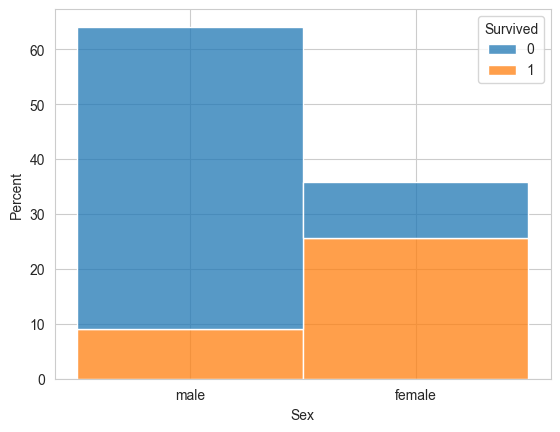

In [4]:
# summary statistics for survival by gender
sns.histplot(x=df_raw['Sex'], hue=df_raw['Survived'].astype(str), multiple="stack", stat="percent")
df_raw[['Sex', 'Survived']].groupby('Sex').value_counts(normalize=True).to_frame()

In [5]:
#df['Survived'] = df['Survived'].astype(str)
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df_raw[columns].dropna()
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df = df.drop(['Sex_male', 'Pclass_3', 'Embarked_S'], axis = 1)

In [6]:
df.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Pclass_1,Pclass_2,Embarked_C,Embarked_Q
0,0,22.0,1,0,7.2500,False,False,False,False,False
1,1,38.0,1,0,71.2833,True,True,False,True,False
2,1,26.0,0,0,7.9250,True,False,False,False,False
3,1,35.0,1,0,53.1000,True,True,False,False,False
4,0,35.0,0,0,8.0500,False,False,False,False,False


## Train Python Models

In [7]:
features = df.drop('Survived', axis=1).columns
target = 'Survived'

X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[target], train_size=0.7, test_size=0.3,
                                                    random_state=42)

In [8]:
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

dtc.fit(X_train, Y_train)
rfc.fit(X_train, Y_train)
gbc.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=42)

## Assess Models

In [9]:
# Calculate the importance of a predictor
def sort_feature_importance(model, data):
    features = {}
    for importance, name in sorted(zip(model.feature_importances_, data.columns), reverse=True):
        features[name] = str(np.round(importance*100, 2)) + "%"
    return features

In [10]:
importances = pd.DataFrame.from_dict(sort_feature_importance(dtc, X_train), orient="index").rename(columns={0: "DecisionTree"})
importances["RandomForest"] = pd.DataFrame.from_dict(sort_feature_importance(rfc, X_train), orient="index")
importances["GradientBoosting"] = pd.DataFrame.from_dict(sort_feature_importance(gbc, X_train), orient="index")
importances

,DecisionTree,RandomForest,GradientBoosting
Sex_female,35.19%,29.75%,37.51%
Fare,28.41%,24.44%,27.86%
Age,25.94%,22.93%,21.1%
SibSp,5.46%,8.0%,8.0%
Pclass_1,5.01%,3.2%,1.31%
Pclass_2,0.0%,3.42%,2.71%
Parch,0.0%,4.38%,0.15%
Embarked_Q,0.0%,0.55%,0.34%
Embarked_C,0.0%,3.33%,1.02%


In [11]:
y_dtc_predict = dtc.predict(X_test)
y_dtc_proba = dtc.predict_proba(X_test)
print(confusion_matrix(Y_test, y_dtc_predict))
print(classification_report(Y_test, y_dtc_predict))
print("Decision Tree Model Accuracy = " + str(np.round(dtc.score(X_test, Y_test)*100,2)) + "%")

[[26  3]
 [ 5  4]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.57      0.44      0.50         9

    accuracy                           0.79        38
   macro avg       0.71      0.67      0.68        38
weighted avg       0.78      0.79      0.78        38

Decision Tree Model Accuracy = 78.95%


In [12]:
y_rfc_predict = rfc.predict(X_test)
y_rfc_proba = rfc.predict_proba(X_test)
print(confusion_matrix(Y_test, y_rfc_predict))
print(classification_report(Y_test, y_rfc_predict))
print("Random Forest Model Accuracy = " + str(np.round(rfc.score(X_test, Y_test)*100,2)) + "%")

[[26  3]
 [ 5  4]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.57      0.44      0.50         9

    accuracy                           0.79        38
   macro avg       0.71      0.67      0.68        38
weighted avg       0.78      0.79      0.78        38

Random Forest Model Accuracy = 78.95%


In [13]:
y_gbc_predict = gbc.predict(X_test)
y_gbc_proba = gbc.predict_proba(X_test)
print(confusion_matrix(Y_test, y_gbc_predict))
print(classification_report(Y_test, y_gbc_predict))
print("Gradient Boosting Model Accuracy = " + str(np.round(gbc.score(X_test, Y_test)*100,2)) + "%")

[[25  4]
 [ 5  4]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.50      0.44      0.47         9

    accuracy                           0.76        38
   macro avg       0.67      0.65      0.66        38
weighted avg       0.75      0.76      0.76        38

Gradient Boosting Model Accuracy = 76.32%


## Create Score Tables

In [10]:
# recreating sex variable
sex = X_test['Sex_female'].apply(lambda x: 'female' if x else 'male')

In [11]:
def build_score_table(model):
    score_data = {'P_Survived1': model.predict_proba(X_test)[:,1],
                  'P_Survived0': model.predict_proba(X_test)[:,0],
                  'Survived': Y_test.to_numpy(),
                  'Sex': sex}
    data = pd.DataFrame(score_data)
    return data

In [12]:
score_tables = {"DecisionTree": build_score_table(dtc),
                "RandomForest": build_score_table(rfc),
                "GradientBoost": build_score_table(gbc)}

In [13]:
for k,v in score_tables.items():
    print(f'{k} \n {v.head()}')

DecisionTree 
     P_Survived1  P_Survived0  Survived     Sex
21          0.0          1.0         1    male
57          0.0          1.0         0    male
50          0.0          1.0         0    male
99          0.0          1.0         0    male
71          0.0          1.0         0  female
RandomForest 
     P_Survived1  P_Survived0  Survived     Sex
21         0.01         0.99         1    male
57         0.31         0.69         0    male
50         0.24         0.76         0    male
99         0.04         0.96         0    male
71         0.51         0.49         0  female
GradientBoost 
     P_Survived1  P_Survived0  Survived     Sex
21     0.006381     0.993619         1    male
57     0.320892     0.679108         0    male
50     0.239965     0.760035         0    male
99     0.008723     0.991277         0    male
71     0.971452     0.028548         0  female


## Get File Properties

In [14]:
# setting up environment
hostname = 'green.ingress-nginx.rint08-0020.race.sas.com'
username = 'edmdev'
password = 'Go4thsas'

sess = Session(hostname, username, password, protocol='http')

In [15]:
# Model names within SAS Model Manager
model_prefix = ["DecisionTree", "RandomForest", "GradientBoost"]
# Directory location for the model files
zip_folder = [Path.cwd() / "data/BiasMetrics/titanicModels/DecisionTree/",
             Path.cwd() / "data/BiasMetrics/titanicModels/RandomForest/",
             Path.cwd() / "data/BiasMetrics/titanicModels/GradientBoost"] # Changes required by user
model = [dtc, rfc, gbc]
# Output variables expected in SAS Model Manager. If a classification value is expected to be output, it should be the first metric.
score_metrics = ["EM_CLASSIFICATION", "EM_EVENTPROBABILITY"]

In [16]:
# creating assess bias json files and getting dataframes
assess_bias_dfs = {}

for (model, path) in zip(model_prefix, zip_folder):
    dfs = pzmm.JSONFiles.assess_model_bias(
        score_table=score_tables[model],
        actual_values='Survived',
        sensitive_values='Sex',
        prob_values=['P_Survived1', 'P_Survived0'],
        levels=['1', '0'],
        json_path=path,
        return_dataframes=True # returns group metrics and max differences data frames
    )

    assess_bias_dfs[model] = dfs

maxDifferences.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\maxDifferences.json
groupMetrics.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\groupMetrics.json
maxDifferences.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest\maxDifferences.json
groupMetrics.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest\groupMetrics.json
maxDifferences.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\GradientBoost\maxDifferences.json
groupMetrics.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMe

## Assess Model Bias Output

### Example Data Frames

In [17]:
assess_bias_dfs['DecisionTree']['groupMetricsData'].head()

,INTO_EVENT,LEVEL,PREDICTED_EVENT,P_Survived0,P_Survived1,VLABEL,_DATAROLE_,_VARIABLE_,_acc_,_ase_,...,_mcll_,_misccutoff_,_miscks_,_nobs_,_rase_,_resp_,_tn_,_tnr_,_tp_,_tpr_
0,0.600000,female,0.600000,0.400000,0.600000,,TEST,Sex,0.600000,0.400000,...,9.210340,0.400000,0.400000,10.0,0.632456,11.111111,2.0,0.50,4.0,0.666667
1,0.035714,male,0.035714,0.964286,0.035714,,TEST,Sex,0.857143,0.142857,...,3.289407,0.142857,0.892857,28.0,0.377964,7.407407,24.0,0.96,0.0,0.000000


In [18]:
assess_bias_dfs['DecisionTree']['maxDifferencesData'].head()

,BASE,COMPARE,Metric,MetricLabel,VLABEL,_DATAROLE_,_VARIABLE_,maxdiff
0,female,male,P_Survived1,Average P_Survived1,,TEST,Sex,0.564286
1,male,female,P_Survived0,Average P_Survived0,,TEST,Sex,0.564286
2,female,male,TPR,True Positive Rate,,TEST,Sex,0.666667
3,female,male,FPR,False Positive Rate,,TEST,Sex,0.460000
4,male,female,TNR,True Negative Rate,,TEST,Sex,0.460000


In [19]:
assess_bias_dfs['DecisionTree']['biasMetricsData'].head()

,Metric,MetricLabel,Value,Base,Compare,Note,_VARIABLE_
0,DemographicParity,Demographic Parity (Statistical Parity),0.564286,female,male,,Sex
1,PredictiveParity,Predictive Parity,0.564286,female,male,,Sex
2,EqualAccuracy,Equal Accuracy,0.257143,male,female,,Sex
3,EqualizedOdds,Equalized Odds,0.666667,female,male,The maximum TPR difference is greater than the...,Sex
4,EqualOpportunity,Equal Opportunity,0.666667,female,male,,Sex


### Performance Bias

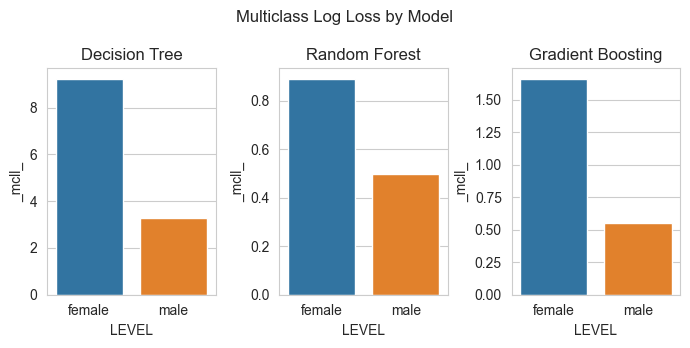

In [90]:
fig, axes = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = [7, 4]
plt.rcParams["figure.autolayout"] = True

fig.suptitle("Multiclass Log Loss by Model")

sns.barplot(data=assess_bias_dfs['DecisionTree']['groupMetricsData'], x="LEVEL", y='_mcll_', ax=axes[0]).set(title="Decision Tree")
sns.barplot(data=assess_bias_dfs['RandomForest']['groupMetricsData'], x="LEVEL", y='_mcll_', ax=axes[1]).set(title="Random Forest")
sns.barplot(data=assess_bias_dfs['GradientBoost']['groupMetricsData'], x="LEVEL", y='_mcll_', ax=axes[2]).set(title="Gradient Boosting")

plt.show()

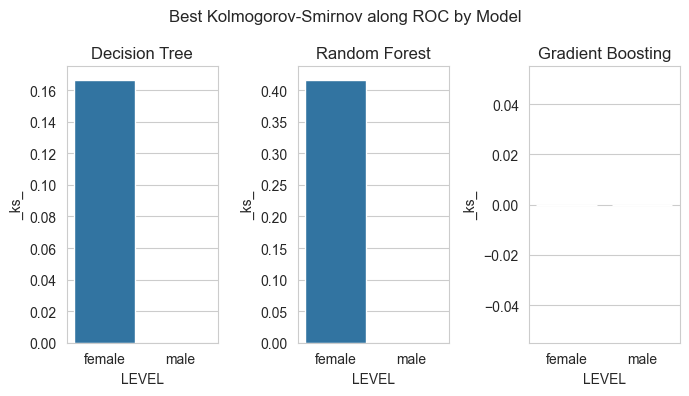

In [91]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Best Kolmogorov-Smirnov along ROC by Model")

sns.barplot(data=assess_bias_dfs['DecisionTree']['groupMetricsData'], x="LEVEL", y='_ks_', ax=axes[0]).set(title="Decision Tree")
sns.barplot(data=assess_bias_dfs['RandomForest']['groupMetricsData'], x="LEVEL", y='_ks_', ax=axes[1]).set(title="Random Forest")
sns.barplot(data=assess_bias_dfs['GradientBoost']['groupMetricsData'], x="LEVEL", y='_ks_', ax=axes[2]).set(title="Gradient Boosting")

plt.show()

### Average Prediction for Event

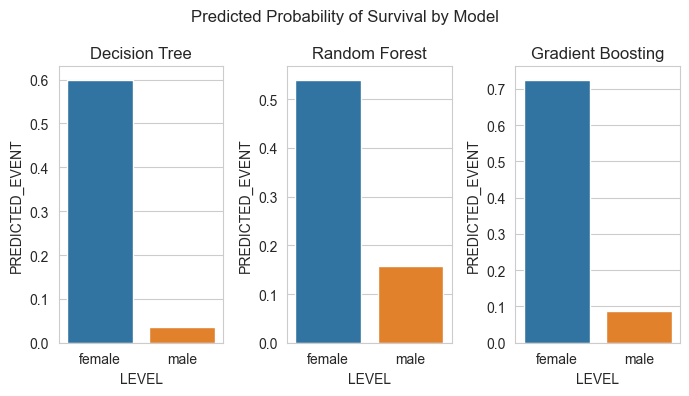

In [92]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Predicted Probability of Survival by Model")

sns.barplot(data=assess_bias_dfs['DecisionTree']['groupMetricsData'], x="LEVEL", y='PREDICTED_EVENT', ax=axes[0]).set(title="Decision Tree")
sns.barplot(data=assess_bias_dfs['RandomForest']['groupMetricsData'], x="LEVEL", y='PREDICTED_EVENT', ax=axes[1]).set(title="Random Forest")
sns.barplot(data=assess_bias_dfs['GradientBoost']['groupMetricsData'], x="LEVEL", y='PREDICTED_EVENT', ax=axes[2]).set(title="Gradient Boosting")

plt.show()

## Other Files for MM Import

In [136]:
# Serialize the models to a pickle format
for (mod, prefix, path) in zip(model, model_prefix, zip_folder):
    pzmm.PickleModel.pickle_trained_model(
        model_prefix=prefix,
        trained_model=mod,
        pickle_path=path
    )

Model DecisionTree was successfully pickled and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\DecisionTree.pickle.
Model RandomForest was successfully pickled and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest\RandomForest.pickle.
Model GradientBoost was successfully pickled and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\GradientBoost\GradientBoost.pickle.


In [39]:
def write_json_files(data, predict, target, path, prefix):
    # Write input variable mapping to a json file
    pzmm.JSONFiles.write_var_json(input_data=data[predict], is_input=True, json_path=path)

    # Set output variables and assign an event threshold, then write output variable mapping
    output_var = pd.DataFrame(columns=score_metrics, data=[["A", 0.5]]) # data argument includes example expected types for outputs
    pzmm.JSONFiles.write_var_json(output_var, is_input=False, json_path=path)

    # Write model properties to a json file
    pzmm.JSONFiles.write_model_properties_json(
        model_name=prefix,
        target_variable=target, # Target variable to make predictions about (Survived in this case)
        target_values=["1", "0"], # Possible values for the target variable (1 or 0 for binary classification of Survived)
        json_path=path,
        model_desc=f"Description for the {prefix} model.",
        model_algorithm="",
        modeler="sasdemo",
    )

    # Write model metadata to a json file so that SAS Model Manager can properly identify all model files
    pzmm.JSONFiles.write_file_metadata_json(model_prefix=prefix, json_path=path)

for (prefix, path) in zip(model_prefix, zip_folder):
    write_json_files(df, features, target, path, prefix)

inputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\inputVar.json
outputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\outputVar.json
ModelProperties.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\ModelProperties.json
fileMetadata.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\fileMetadata.json
inputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest\inputVar.json
outputVar.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest

In [142]:
def write_model_stats(x_train, y_train, test_proba, y_test, model, path):
    # Calculate train predictions
    train_proba = model.predict_proba(x_train)

    # Assign data to lists of actual and predicted values
    train_data = pd.concat([y_train.reset_index(drop=True), pd.Series(data=train_proba[:,1])], axis=1)
    test_data = pd.concat([y_test.reset_index(drop=True), pd.Series(data=test_proba[:,1])], axis=1)

    # Calculate the model statistics, ROC chart, and Lift chart; then write to json files
    pzmm.JSONFiles.calculate_model_statistics(
        target_value=1,
        prob_value=0.5,
        train_data=train_data,
        test_data=test_data,
        json_path=path
    )

conn = sess.as_swat() # Connect to SWAT through the sasctl authenticated connection

test_proba = [dtc.predict_proba(X_test), rfc.predict_proba(X_test), gbc.predict_proba(X_test)]
for (mod, proba, path) in zip(model, test_proba, zip_folder):
    write_model_stats(X_train, Y_train.astype(int), proba, Y_test.astype(int), mod, path)

dmcas_fitstat.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\dmcas_fitstat.json
dmcas_roc.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\dmcas_roc.json
dmcas_lift.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\dmcas_lift.json
dmcas_fitstat.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest\dmcas_fitstat.json
dmcas_roc.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest\dmcas_roc.json
dmcas_lift.json was successfully written and saved to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomF

In [143]:
for (prefix, path) in zip(model_prefix, zip_folder):
    pzmm.ImportModel.import_model(
        model_files=path, # Where are the model files?
        model_prefix=prefix, # What is the model name?
        project="titanicModels", # What is the project name?
        input_data=df[features], # What does example input data look like?
        predict_method=[dtc.predict_proba, [int, int]], # What is the predict method and what does it return?
        score_metrics=score_metrics, # What are the output variables?
        overwrite_model=True, # Overwrite the model if it already exists?
        target_values=["1", "0"], # What are the expected values of the target variable?
        model_file_name=prefix + ".pickle", # How was the model file serialized?
        missing_values=True # Does the data include missing values?
    )
    # Reinitialize the score_code variable when writing more than one model's score code
    pzmm.ScoreCode.score_code = ""

C:\Users\elmcfa\PycharmProjects\python-sasctl\src\sasctl\pzmm\write_score_code.py:1040: UserWarning: Due to the ambiguity of the provided metrics and prediction return types, the score code assumes that a classification and the target event probability should be returned.
  warn(
C:\Users\elmcfa\PycharmProjects\python-sasctl\src\sasctl\pzmm\import_model.py:45: UserWarning: No project with the name or UUID titanicModels was found.
  warn(f"No project with the name or UUID {project} was found.")


Model score code was written successfully to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree\score_DecisionTree.py and uploaded to SAS Model Manager.
All model files were zipped to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\DecisionTree.
A new project named titanicModels was created.
Model was successfully imported into SAS Model Manager as DecisionTree with the following UUID: 9186fdfc-85c0-4b73-8ff3-4fd82b5a76a8.
Model score code was written successfully to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest\score_RandomForest.py and uploaded to SAS Model Manager.
All model files were zipped to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\RandomForest.


C:\Users\elmcfa\PycharmProjects\python-sasctl\src\sasctl\pzmm\write_score_code.py:1040: UserWarning: Due to the ambiguity of the provided metrics and prediction return types, the score code assumes that a classification and the target event probability should be returned.
  warn(


Model was successfully imported into SAS Model Manager as RandomForest with the following UUID: 0c654c16-e1c9-4802-8673-cf06979d4b60.
Model score code was written successfully to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\GradientBoost\score_GradientBoost.py and uploaded to SAS Model Manager.
All model files were zipped to C:\Users\elmcfa\PycharmProjects\python-sasctl\examples\data\BiasMetrics\titanicModels\GradientBoost.


C:\Users\elmcfa\PycharmProjects\python-sasctl\src\sasctl\pzmm\write_score_code.py:1040: UserWarning: Due to the ambiguity of the provided metrics and prediction return types, the score code assumes that a classification and the target event probability should be returned.
  warn(


Model was successfully imported into SAS Model Manager as GradientBoost with the following UUID: 3c0e9bfe-03ac-43f0-93d4-1e56ac17a483.
